# Mixture of 3 Log-Normals with NGBoost

**Problem**: Regression on positive, potentially multimodal data — when the
outcome has multiple "regimes" or clusters.

**When to use**:
- Insurance claims: small routine claims vs. medium claims vs. large catastrophic losses
- Income modeling: multi-peaked income distributions across different job sectors
- Response times: fast automatic responses vs. slower deliberate responses
- Energy consumption: different usage patterns (off-peak, normal, peak)
- Any positive outcome where a single unimodal distribution is a poor fit

**How it works**: 8 parameters — 3 component means, 3 component std devs,
and 2 mixture weight logits (3rd weight is determined by the constraint that
weights sum to 1). The factory auto-derives all 8 gradients and the 8x8
Fisher Information from the symbolic mixture PDF.

**What this notebook shows**: The most advanced pattern — arbitrary custom
PDFs with many parameters, custom fit initialization, custom sampling, and
a monkey-patched analytical mean.

In [2]:
import numpy as np
import sympy as sp
import scipy.stats
from sklearn.model_selection import train_test_split

from ngboost import NGBRegressor
from ngboost.distns.sympy_utils import make_distribution

## 1. Define the mixture PDF symbolically

8 parameters:
- `mu1, mu2, mu3` — component means (identity link)
- `sigma1, sigma2, sigma3` — component std devs (log link, positive)
- `logit_w1, logit_w2` — mixture weights via softmax (3rd logit fixed at 0)

In [3]:
# Symbols
mu1, mu2, mu3 = sp.symbols("mu1 mu2 mu3")
sigma1, sigma2, sigma3 = sp.symbols("sigma1 sigma2 sigma3", positive=True)
logit_w1, logit_w2 = sp.symbols("logit_w1 logit_w2")
y = sp.symbols("y", positive=True)

# Mixture weights via softmax (3rd logit fixed at 0)
e1, e2 = sp.exp(logit_w1), sp.exp(logit_w2)
Z = e1 + e2 + 1
w1, w2, w3 = e1 / Z, e2 / Z, 1 / Z


def lognorm_pdf(y, mu, sigma):
    return sp.exp(-((sp.log(y) - mu) ** 2) / (2 * sigma**2)) / (
        y * sigma * sp.sqrt(2 * sp.pi)
    )


# Mixture PDF and score
mixture_pdf = (
    w1 * lognorm_pdf(y, mu1, sigma1)
    + w2 * lognorm_pdf(y, mu2, sigma2)
    + w3 * lognorm_pdf(y, mu3, sigma3)
)
score_expr = -sp.log(mixture_pdf)

print("Mixture PDF defined with 8 parameters.")
print(f"  Components: 3 LogNormals")
print(f"  Weight params: logit_w1, logit_w2 (softmax with 3rd fixed at 0)")

Mixture PDF defined with 8 parameters.
  Components: 3 LogNormals
  Weight params: logit_w1, logit_w2 (softmax with 3rd fixed at 0)


## 2. Custom fit and sample functions

Mixtures need domain-aware initialization — the auto MLE fit (starting from
zeros) is impractical with 8 parameters and a multimodal likelihood.
Sampling also requires knowing the mixture structure (pick component, then sample).

These are the only two manual pieces; the factory handles score, gradient,
Fisher Information, and mean (via sampling fallback) automatically.

In [4]:
def fit_mixture(Y):
    """Initialize parameters from data using quantile splitting on log(Y)."""
    log_Y = np.log(np.clip(Y, 1e-10, None))
    sorted_log_Y = np.sort(log_Y)
    n = len(sorted_log_Y)

    g1 = sorted_log_Y[: n // 3]
    g2 = sorted_log_Y[n // 3 : 2 * n // 3]
    g3 = sorted_log_Y[2 * n // 3 :]

    m1, m2, m3 = np.mean(g1), np.mean(g2), np.mean(g3)
    s1, s2, s3 = max(np.std(g1), 0.1), max(np.std(g2), 0.1), max(np.std(g3), 0.1)

    # [mu1, mu2, mu3, log(sigma1), log(sigma2), log(sigma3), logit_w1, logit_w2]
    return np.array([m1, m2, m3, np.log(s1), np.log(s2), np.log(s3), 0.0, 0.0])


def sample_mixture(self, m):
    """Sample by first choosing a component, then sampling from that LogNormal."""
    e1 = np.exp(np.atleast_1d(self.logit_w1))
    e2 = np.exp(np.atleast_1d(self.logit_w2))
    Z = e1 + e2 + 1
    w1_arr, w2_arr, w3_arr = e1 / Z, e2 / Z, 1 / Z

    mu1 = np.atleast_1d(self.mu1)
    mu2 = np.atleast_1d(self.mu2)
    mu3 = np.atleast_1d(self.mu3)
    sig1 = np.atleast_1d(self.sigma1)
    sig2 = np.atleast_1d(self.sigma2)
    sig3 = np.atleast_1d(self.sigma3)

    n_obs = len(mu1)
    results = np.zeros((m, n_obs))
    for s in range(m):
        u = np.random.random(n_obs)
        c1 = u < w1_arr
        c2 = (~c1) & (u < w1_arr + w2_arr)
        c3 = ~(c1 | c2)
        if c1.any():
            results[s, c1] = np.random.lognormal(mu1[c1], sig1[c1])
        if c2.any():
            results[s, c2] = np.random.lognormal(mu2[c2], sig2[c2])
        if c3.any():
            results[s, c3] = np.random.lognormal(mu3[c3], sig3[c3])
    return results


print("Custom fit and sample functions defined.")

Custom fit and sample functions defined.


## 3. Create the distribution

In [5]:
MixtureLN3 = make_distribution(
    params=[
        (mu1, False),
        (mu2, False),
        (mu3, False),
        (sigma1, True),
        (sigma2, True),
        (sigma3, True),
        (logit_w1, False),
        (logit_w2, False),
    ],
    y=y,
    score_expr=score_expr,
    fit_fn=fit_mixture,
    sample_fn=sample_mixture,
    name="MixtureLN3",
)

print(f"Created: {MixtureLN3}")
print(f"  n_params: {MixtureLN3.n_params}")
print(f"  mean() uses sampling fallback (no scipy class)")

Created: <class 'ngboost.distns.sympy_utils.MixtureLN3'>
  n_params: 8
  mean() uses sampling fallback (no scipy class)


## 4. Generate synthetic multimodal positive data

In [6]:
np.random.seed(42)
n_samples = 1500
n_features = 5

X = np.random.randn(n_samples, n_features)

# True component means shift with features
true_mu1 = 1.0 + 1.3 * X[:, 0]
true_mu2 = 3.0 - 1.2 * X[:, 1]
true_mu3 = 5.0 + 1.1 * X[:, 2]

# Fixed sigmas and weights
true_sigma = [0.3, 0.4, 0.3]
true_weights = [0.4, 0.35, 0.25]

# Sample from the mixture
components = np.random.choice(3, size=n_samples, p=true_weights)
Y = np.zeros(n_samples)
for i in range(n_samples):
    k = components[i]
    mu_k = [true_mu1[i], true_mu2[i], true_mu3[i]][k]
    Y[i] = np.random.lognormal(mu_k, true_sigma[k])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.2f}, {Y.max():.2f}]")
print(f"Y mean: {Y.mean():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.08, 2151.86]
Y mean: 79.16
Train: 1200, Test: 300


In [7]:
components

array([2, 0, 1, ..., 0, 2, 1])

## 5. Train NGBoost

With 8 parameters, building and training takes significantly longer than simpler
distributions. The factory needs to symbolically differentiate the 8-parameter
score expression (once, at class creation time), and the Fisher Information
falls back to Monte Carlo estimation during training.

**Expect a few minutes of training time.**

In [8]:
from sklearn.tree import DecisionTreeRegressor
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    splitter="best",
    random_state=None,
)

ngb = NGBRegressor(
    Dist=MixtureLN3,
    Base=tree_learner,
    n_estimators=1000,
    learning_rate=0.05,
    verbose=False,
    random_state=42,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 6. Predictions and parameters

In [9]:
Y_pred = ngb.predict(X_test)
dists = ngb.pred_dist(X_test)

# Compute mixture weights for first 5 test samples
e1 = np.exp(dists.logit_w1[:5])
e2 = np.exp(dists.logit_w2[:5])
Z = e1 + e2 + 1

print("Component parameters (first 5 test samples):")
print(f"  mu1: {dists.mu1[:5].round(3)}")
print(f"  mu2: {dists.mu2[:5].round(3)}")
print(f"  mu3: {dists.mu3[:5].round(3)}")
print(f"  sigma1: {dists.sigma1[:5].round(3)}")
print(f"  sigma2: {dists.sigma2[:5].round(3)}")
print(f"  sigma3: {dists.sigma3[:5].round(3)}")
print(f"\nMixture weights (first 5):")
print(f"  w1: {(e1 / Z).round(3)}")
print(f"  w2: {(e2 / Z).round(3)}")
print(f"  w3: {(1 / Z).round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5].round(2)}")

Component parameters (first 5 test samples):
  mu1: [ 1.677 -0.26   0.185 -0.212  0.38 ]
  mu2: [2.847 0.472 2.835 2.993 1.8  ]
  mu3: [5.881 5.874 4.903 5.133 4.253]
  sigma1: [0.121 0.134 0.271 0.172 0.092]
  sigma2: [0.27  0.157 0.268 0.095 0.164]
  sigma3: [0.428 0.301 0.233 0.224 0.385]

Mixture weights (first 5):
  w1: [0.058 0.612 0.496 0.48  0.001]
  w2: [0.629 0.001 0.297 0.002 0.608]
  w3: [0.313 0.387 0.207 0.518 0.39 ]

Predicted mean (first 5): [115.2  141.43  30.77  89.92  33.26]
Actual (first 5):          [ 26.93   1.36   1.21 115.36  10.31]


## 7. Visualize

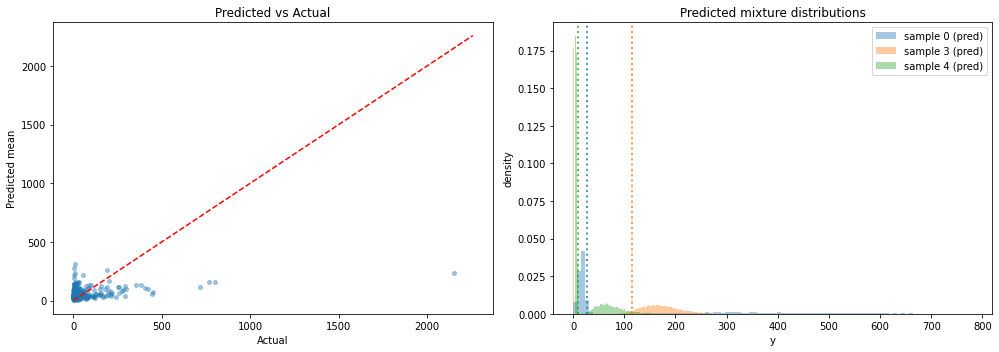

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.4, s=15)
lims = [0, max(Y_test.max(), Y_pred.max()) * 1.05]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

# Right: predicted mixture density for 2 test samples (via sampling)
ax = axes[1]
idxs = [0, 3, 4]
for idx in idxs:
    s = dists[idx].sample(20000)
    ax.hist(s, bins=100, density=True, alpha=0.4,
            range=(0, np.percentile(s, 99)),
            label=f"sample {idx} (pred)")
    ax.axvline(Y_test[idx], color=f"C{idxs.index(idx)}",
               linestyle=":", linewidth=2, alpha=0.8)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted mixture distributions")
ax.legend()

plt.tight_layout()
plt.show()

## Summary

Even complex distributions with many parameters work with `make_distribution`.
The automation spectrum:

| Pattern | What you provide | What the factory handles |
|---|---|---|
| **Standard** (Beta, Normal) | sympy.stats + scipy.stats | everything |
| **Manual score** (LogitNormal) | score_expr + sample_fn | score, grad, FI, fit (MLE), mean (sampling) |
| **Complex** (Mixtures) | score_expr + fit_fn + sample_fn | score, grad, FI, mean (sampling) |

Mixtures need custom `fit_fn` (smart initialization) and `sample_fn`
(component selection logic), but the factory still auto-derives all 8
gradients and the 8x8 Fisher Information from the symbolic expression.